In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

SyntaxError: incomplete input (4179869896.py, line 17)

In [3]:
import numpy as np
import os
import glob
import time

# importing data
event_types = {1:'GRB',2:'TGF',3:'SGR',4:'SFLARE'}

test_dir = os.path.join('/kaggle/input/dcl-00/DCL_ds0/test')  
train_dir = os.path.join('/kaggle/input/dcl-00/DCL_ds0/train')

# Replace 'your_search_string' with the string you are looking for in file names
search_string = 'bn'

search_pattern = os.path.join(test_dir, f'*{search_string}*')
test_files = glob.glob(search_pattern)

search_pattern = os.path.join(train_dir, f'*{search_string}*')
train_files = glob.glob(search_pattern)
print(len(test_files))
print(test_files[:10])

print(len(train_files))
print(train_files[:10])
import json

json_data_path = '/kaggle/input/dcl-00/DCL_ds0/params.json'
with open(json_data_path, 'r') as file:
    try:
        json_data = json.load(file)
        print(json_data)
    except json.JSONDecodeError:
        print(f"Error: JSON decode failed for file '{file_path}'")


784
['/kaggle/input/dcl-00/DCL_ds0/test/GRB_bn170113420', '/kaggle/input/dcl-00/DCL_ds0/test/SFLARE_bn141216438', '/kaggle/input/dcl-00/DCL_ds0/test/SFLARE_bn131029420', '/kaggle/input/dcl-00/DCL_ds0/test/SGR_bn221013037d', '/kaggle/input/dcl-00/DCL_ds0/test/GRB_bn171010875', '/kaggle/input/dcl-00/DCL_ds0/test/SGR_bn160715298', '/kaggle/input/dcl-00/DCL_ds0/test/GRB_bn220407167', '/kaggle/input/dcl-00/DCL_ds0/test/TGF_bn140628393', '/kaggle/input/dcl-00/DCL_ds0/test/TGF_bn180607061', '/kaggle/input/dcl-00/DCL_ds0/test/TGF_bn180922713']
3200
['/kaggle/input/dcl-00/DCL_ds0/train/SGR_bn160626724', '/kaggle/input/dcl-00/DCL_ds0/train/GRB_bn230911329', '/kaggle/input/dcl-00/DCL_ds0/train/TGF_bn160416676', '/kaggle/input/dcl-00/DCL_ds0/train/GRB_bn150322066', '/kaggle/input/dcl-00/DCL_ds0/train/GRB_bn120312671', '/kaggle/input/dcl-00/DCL_ds0/train/TGF_bn110606097', '/kaggle/input/dcl-00/DCL_ds0/train/SFLARE_bn100212307', '/kaggle/input/dcl-00/DCL_ds0/train/GRB_bn140110411', '/kaggle/input/dc

In [4]:
dno = json_data['number of data points']

try:
    chrn = len(json_data['channel ranges'])
except:
    chrn = 1
    
try:
    t = json_data['time interval'][1]-json_data['time interval'][0]
except:
    t='n/a'
    
# Calculating the number of points in each binnning
bin_list = json_data['bin list']
dno_list = (chrn * len(bin_list)) * [dno]
data_total = sum(dno_list)
check_data = np.loadtxt(train_files[1], delimiter='\t').astype(np.int32)
len_data = len(check_data)
print(dno_list)

if data_total == len_data and len(dno_list) == len(bin_list) * chrn:
    print('bin edges calculated correctly')
else:
    print('inconsistency in bin edges calculated and data')
    print(data_total)
    print(len_data)
    
print('channel range no',chrn)
print('number of data points',dno)
print('time interval',t)

[499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499, 499]
bin edges calculated correctly
channel range no 2
number of data points 499
time interval n/a


In [5]:
zerofiles = []
c = 0
for file in train_files:
    check = np.loadtxt(file, delimiter='\t').astype(np.int32)
    if np.all(check == 0):
        c +=1
        zerofiles.append(file)
print(c)

338


In [6]:
import numpy as np

def process_file(file, X, Y, event_counter, dno_list):
    """
    Processes a single file and adds its data to the dataset.
    file: path to the file to be processed
    X: list of datasets to be appended to
    Y: list of labels of data
    event_counter: dictionary counting events
    dno_list: list of number of data points in each binning as calculated previously
    
    Returns updated X, Y, and event_counter
    """
    # Fetch data from file and check if label is considered
    event_type, event_name = file.split('/')[-1].split('_')
    loaded_data = np.loadtxt(file, delimiter='\t').astype(np.int32)
    
    if event_type not in event_counter:
        return X, Y, event_counter
    
    y = [0, 0, 0, 0]
    
    # Setting and updating Y
    for key, value in event_types.items():
        if value in file.split('\\')[-1]:
            y[key - 1] = 1
            Y.append(y)
            event_counter[value] += 1
    
    channel_1_data = []
    channel_2_data = []

    # Initialize lists to hold data slices
    for i in range(0,len(loaded_data),998):
        channel_1_data.extend(loaded_data[i:i+499])
        channel_2_data.extend(loaded_data[i+499:i+998])
    
    X.append([channel_1_data, channel_2_data])
    
    return X, Y, event_counter

In [7]:
# initializing train and test sets
X_train = []
Y_train = []
train_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

X_test = []
Y_test = []
test_event_counter = {'GRB':0,'TGF':0,'SGR':0,'SFLARE':0}

# print(process_file(train_files[1],X_train,Y_train,train_event_counter))

# processing train and test data sets
for file in train_files:
    X_train,Y_train,train_event_counter = process_file(file,X_train,Y_train,train_event_counter,dno_list)
print('training events\n',train_event_counter)
print('total events : ', sum([i for i in train_event_counter.values()]))
Y_train = np.array(Y_train)
X_train = np.array(X_train)
print('shape of Y_train', Y_train.shape)
print('shape of X_train', X_train.shape)

for file in test_files:
    X_test,Y_test,test_event_counter = process_file(file,X_test,Y_test,test_event_counter,dno_list)
print('testing events\n',test_event_counter)
print('total events : ', sum([i for i in test_event_counter.values()]))
Y_test = np.array(Y_test)
X_test = np.array(X_test)
print('shape of Y_test', Y_test.shape)
print('shape of X_test', X_test.shape)
print(X_train[1:2])


training events
 {'GRB': 800, 'TGF': 800, 'SGR': 800, 'SFLARE': 800}
total events :  3200
shape of Y_train (3200, 4)
shape of X_train (3200, 2, 3493)
testing events
 {'GRB': 200, 'TGF': 200, 'SGR': 184, 'SFLARE': 200}
total events :  784
shape of Y_test (784, 4)
shape of X_test (784, 2, 3493)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [8]:
import numpy as np
from scipy.interpolate import interp1d

print("Before augmentation")
print(f"Shape of augmented data: {X_train.shape}")
print(f"Shape of augmented labels: {Y_train.shape}")

def augment_timeseries_data(X, Y, augmentation_factor=1):
    """
    Perform data augmentation on time series data.
    
    Args:
    X (numpy.ndarray): The input data of shape (samples, channels, time_steps).
    Y (numpy.ndarray): The corresponding labels of shape (samples, labels).
    augmentation_factor (int): The factor by which to increase the dataset size.
    
    Returns:
    tuple: (augmented_data, augmented_labels)
    """
    
    augmented_data = []
    
    def time_warp(x, sigma=0.2, knot=4):
        orig_steps = np.arange(x.shape[2])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, x.shape[1]))
        warp_steps = np.linspace(0, x.shape[2]-1., num=knot+2)
        ret = np.zeros_like(x)
        for i in range(x.shape[1]):
            warper = interp1d(warp_steps, random_warps[:, i], kind='linear')
            warped_steps = warper(orig_steps)
            for j in range(x.shape[0]):
                ret[j, i, :] = np.interp(orig_steps, warped_steps, x[j, i, :])
        return ret

    def magnitude_warp(x, sigma=0.2, knot=4):
        orig_steps = np.arange(x.shape[2])
        random_warps = np.random.normal(loc=1.0, scale=sigma, size=(knot+2, x.shape[1]))
        warp_steps = np.linspace(0, x.shape[2]-1., num=knot+2)
        ret = np.zeros_like(x)
        for i in range(x.shape[1]):
            warper = interp1d(warp_steps, random_warps[:, i], kind='linear')
            warped_steps = warper(orig_steps)
            for j in range(x.shape[0]):
                ret[j, i, :] = x[j, i, :] * warped_steps
        return ret

    def window_slice(x, reduce_ratio=0.9):
        target_len = int(reduce_ratio * x.shape[2])
        if target_len >= x.shape[2]:
            return x
        starts = np.random.randint(0, x.shape[2] - target_len, size=(x.shape[0])).astype(int)
        ends = (target_len + starts).astype(int)
        
        ret = np.zeros_like(x)
        for i, (start, end) in enumerate(zip(starts, ends)):
            for j in range(x.shape[1]):
                ret[i, j, :] = np.interp(np.linspace(0, target_len, num=x.shape[2]), 
                                         np.arange(target_len), 
                                         x[i, j, start:end])
        return ret

    for _ in range(augmentation_factor):
        aug_data = X.copy()
        if np.random.rand() > 0.5:
            aug_data = time_warp(aug_data)
        if np.random.rand() > 0.5:
            aug_data = magnitude_warp(aug_data)
        if np.random.rand() > 0.5:
            aug_data = window_slice(aug_data)
        
        augmented_data.append(aug_data)
    
    augmented_data = np.concatenate([X] + augmented_data, axis=0)
    augmented_labels = np.tile(Y, (augmentation_factor + 1, 1))
    
    return augmented_data, augmented_labels


X_augmented, Y_augmented = augment_timeseries_data(X_train, Y_train, augmentation_factor=1)

X_train = X_augmented
Y_train = Y_augmented

print("\nAfter augmentation")

print(f"Shape of augmented data: {X_train.shape}")
print(f"Shape of augmented labels: {Y_train.shape}")

Before augmentation
Shape of augmented data: (3200, 2, 3493)
Shape of augmented labels: (3200, 4)

After augmentation
Shape of augmented data: (6400, 2, 3493)
Shape of augmented labels: (6400, 4)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4134 - loss: 43.6619 - val_accuracy: 0.6138 - val_loss: 21.3437
Epoch 2/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6397 - loss: 12.3939 - val_accuracy: 0.6611 - val_loss: 17.3374
Epoch 3/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6590 - loss: 11.7730 - val_accuracy: 0.7258 - val_loss: 10.3245
Epoch 4/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6879 - loss: 11.9613 - val_accuracy: 0.7704 - val_loss: 9.0984
Epoch 5/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7160 - loss: 11.6125 - val_accuracy: 0.7376 - val_loss: 8.8597
Epoch 6/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7164 - loss: 10.7027 - val_accuracy: 0.7704 - val_loss: 7.2180
Epoch 7/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7419 - loss: 7.6604 - val_accuracy: 0.7815 - val_loss: 7.0480
Epoch 8/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7652 - loss: 8.7253 -

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4554 - loss: 39.7221 - val_accuracy: 0.6917 - val_loss: 10.5587
Epoch 2/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6702 - loss: 15.5416 - val_accuracy: 0.7418 - val_loss: 10.4845
Epoch 3/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7242 - loss: 10.8061 - val_accuracy: 0.7641 - val_loss: 10.1523
Epoch 4/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7555 - loss: 9.7383 - val_accuracy: 0.7523 - val_loss: 9.3497
Epoch 5/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7346 - loss: 9.9413 - val_accuracy: 0.7843 - val_loss: 7.0072
Epoch 6/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.7731 - loss: 8.7842 - val_accuracy: 0.8177 - val_loss: 6.9219
Epoch 7/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7867 - loss: 8.1728 - val_accuracy: 0.7258 - val_loss: 8.6143
Epoch 8/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7373 - loss: 9.5053 - va

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4638 - loss: 38.5479 - val_accuracy: 0.6256 - val_loss: 11.5170
Epoch 2/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6313 - loss: 14.7125 - val_accuracy: 0.7147 - val_loss: 9.3312
Epoch 3/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6845 - loss: 11.2769 - val_accuracy: 0.7390 - val_loss: 8.3761
Epoch 4/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7203 - loss: 8.6008 - val_accuracy: 0.7383 - val_loss: 8.0771
Epoch 5/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7339 - loss: 8.1018 - val_accuracy: 0.7891 - val_loss: 7.6713
Epoch 6/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7742 - loss: 7.6097 - val_accuracy: 0.8045 - val_loss: 6.9092
Epoch 7/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7764 - loss: 8.6431 - val_accuracy: 0.7989 - val_loss: 6.9959
Epoch 8/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7700 - loss: 8.7750 - val_

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4181 - loss: 1427.3345 - val_accuracy: 0.6820 - val_loss: 17.0913
Epoch 2/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5925 - loss: 16.6661 - val_accuracy: 0.7084 - val_loss: 54.2570
Epoch 3/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6361 - loss: 13.9494 - val_accuracy: 0.7578 - val_loss: 12.8179
Epoch 4/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6948 - loss: 9.8054 - val_accuracy: 0.7669 - val_loss: 10.8197
Epoch 5/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6678 - loss: 488.0975 - val_accuracy: 0.7523 - val_loss: 9.5430
Epoch 6/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6891 - loss: 8.3242 - val_accuracy: 0.8058 - val_loss: 8.5314
Epoch 7/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7269 - loss: 7.4185 - val_accuracy: 0.8017 - val_loss: 8.3511
Epoch 8/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7331 - loss: 8.3365

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4828 - loss: 71.5455 - val_accuracy: 0.6358 - val_loss: 11.5056
Epoch 2/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6212 - loss: 20.6666 - val_accuracy: 0.6720 - val_loss: 9.3516
Epoch 3/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6486 - loss: 15.9296 - val_accuracy: 0.7340 - val_loss: 9.0183
Epoch 4/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7044 - loss: 16.6298 - val_accuracy: 0.7890 - val_loss: 8.4479
Epoch 5/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7338 - loss: 12.7302 - val_accuracy: 0.7625 - val_loss: 7.9457
Epoch 6/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7348 - loss: 11.3120 - val_accuracy: 0.7953 - val_loss: 7.4944
Epoch 7/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7759 - loss: 10.8354 - val_accuracy: 0.8189 - val_loss: 7.1826
Epoch 8/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7837 - loss: 8.5026 - 

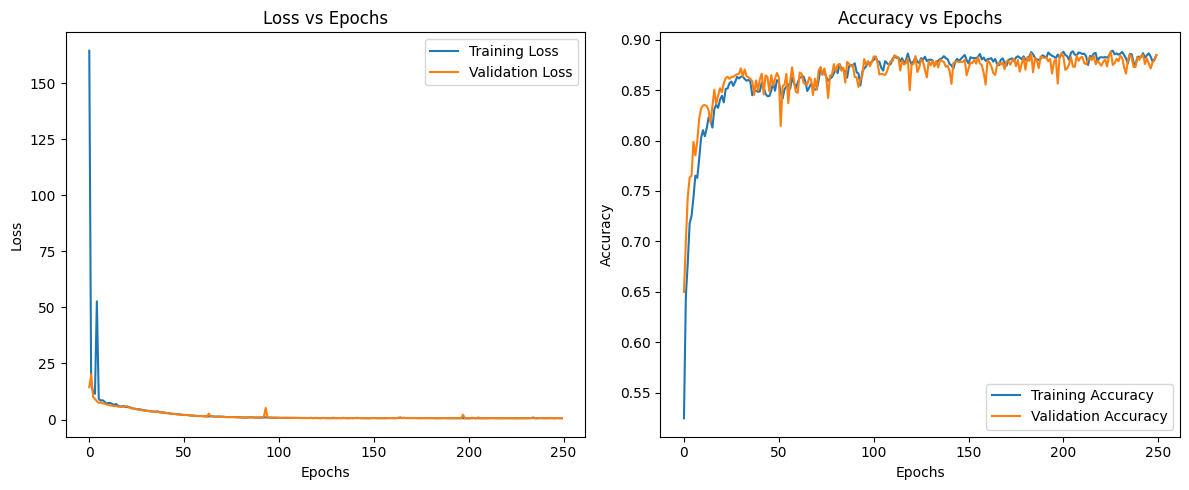

Average accuracy across 5 folds: 0.8849


In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

tf.random.set_seed(42)

# Function to create the CNN model
def create_model():
    model = models.Sequential()
    model.add(layers.Conv1D(32, 1, activation='relu', input_shape=(2, 3493), kernel_regularizer=regularizers.l2(0.02)))
    model.add(layers.MaxPooling1D((1)))
    model.add(layers.Conv1D(32, 1, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(layers.MaxPooling1D((1)))
    model.add(layers.Conv1D(32, 2, activation='relu', kernel_regularizer=regularizers.l2(0.02)))
    model.add(layers.GlobalMaxPooling1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.03)))
    model.add(layers.Dense(4, activation='softmax', kernel_regularizer=regularizers.l2(0.03)))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# K-Fold cross-validation setup
K = 5
kf = KFold(n_splits=K, shuffle=True, random_state=42)

# Concatenate the training and test datasets
X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

# Initialize variables to store results
accuracy_list = []
all_train_loss = []
all_val_loss = []
all_train_acc = []
all_val_acc = []

# Training and evaluation loop for each fold
for train_index, test_index in kf.split(X):
    X_fold_train, X_fold_test = X[train_index], X[test_index]
    Y_fold_train, Y_fold_test = Y[train_index], Y[test_index]
    
    model = create_model()  # Create a new model for each fold
    
    # Train the model
    history = model.fit(X_fold_train, Y_fold_train, epochs=250, batch_size=32, validation_data=(X_fold_test, Y_fold_test))
    
    Y_pred = model.predict(X_fold_test)
    
    # Convert predictions from probabilities to class labels
    Y_pred_labels = np.argmax(Y_pred, axis=1)  # Predicted class indices
    Y_true_labels = np.argmax(Y_fold_test, axis=1)  # True class indices (if one-hot encoded)
    
    # Save the history for learning curves
    all_train_loss.append(history.history['loss'])
    all_val_loss.append(history.history['val_loss'])
    all_train_acc.append(history.history['accuracy'])
    all_val_acc.append(history.history['val_accuracy'])

    
    # Calculate accuracy for this fold
    accuracy = accuracy_score(Y_true_labels, Y_pred_labels)
    accuracy_list.append(accuracy)

# Plot Learning Curves
avg_train_loss = np.mean(all_train_loss, axis=0)
avg_val_loss = np.mean(all_val_loss, axis=0)
avg_train_acc = np.mean(all_train_acc, axis=0)
avg_val_acc = np.mean(all_val_acc, axis=0)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(avg_train_loss, label='Training Loss')
plt.plot(avg_val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(avg_train_acc, label='Training Accuracy')
plt.plot(avg_val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epochs')
plt.legend()

plt.tight_layout()
plt.show()

# Final Test Accuracy (Average of all folds)
average_accuracy = np.mean(accuracy_list)
print(f"Average accuracy across {K} folds: {average_accuracy:.4f}")



25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


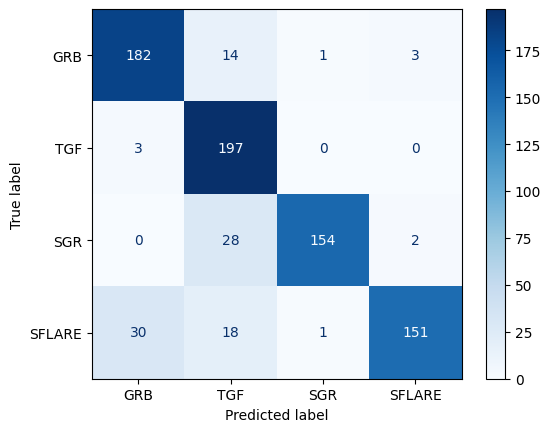

              precision    recall  f1-score   support

         GRB       0.85      0.91      0.88       200
         TGF       0.77      0.98      0.86       200
         SGR       0.99      0.84      0.91       184
      SFLARE       0.97      0.76      0.85       200

    accuracy                           0.87       784
   macro avg       0.89      0.87      0.87       784
weighted avg       0.89      0.87      0.87       784



In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_labels = ['GRB', 'TGF', 'SGR', 'SFLARE']

test_prediction = model.predict(X_test)
test_predicted_label = np.argmax(test_prediction, axis=1)
test_actual_label = np.argmax(Y_test, axis = 1)
conf_m = confusion_matrix(test_actual_label, test_predicted_label)

conf_m_show = ConfusionMatrixDisplay(confusion_matrix = conf_m,display_labels=class_labels)
conf_m_show.plot(include_values=True, cmap='Blues',ax = None, xticks_rotation= 'horizontal')
plt.show()

from sklearn.metrics import classification_report


report = classification_report(test_actual_label, test_predicted_label , labels=[0, 1, 2, 3], target_names=['GRB', 'TGF', 'SGR', 'SFLARE'], zero_division=0)

print(report)

In [14]:
def model_conf_u_optimized(model, X, Y, conf_threshold=0.7):
    predictions = model.predict(X)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)

    # Check if Y is one-hot encoded
    if Y.ndim == 2:  # One-hot encoded case
        true_labels = np.argmax(Y, axis=1)
    else:  # Already class labels
        true_labels = Y

    confident = max_prob > conf_threshold
    correct_predictions = labels == true_labels

    a = np.sum(confident & correct_predictions)
    w = np.sum(confident & ~correct_predictions)
    uncert = np.sum(~confident)

    total = len(Y)
    print('confidently right', a / total)
    print('confidently wrong', w / total)
    print('uncertain', uncert / total)

# Now run with the updated function
model_conf_u_optimized(model, X_test, Y_test, 0.7)


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
confidently right 0.7142857142857143
confidently wrong 0.026785714285714284
uncertain 0.25892857142857145


In [15]:
import numpy as np

def model_conf_optimized(model, X, Y, conf_threshold=0.6):
    conf_right = []
    conf_wrong = []

    predictions = model.predict(X)  # Predict all samples at once
    max_probs = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    #true_labels = np.argmax(Y, axis=1)
    # Check if Y is one-hot encoded
    if Y.ndim == 2:  # One-hot encoded case
        true_labels = np.argmax(Y, axis=1)
    else:  # Already class labels
        true_labels = Y
        
    for n in range(len(Y)):
        max_prob = max_probs[n]
        label = labels[n]
        true_label = true_labels[n]

        if label == true_label and max_prob > conf_threshold:
            conf_right.append(max_prob)
        else:
            conf_wrong.append(max_prob)

    return len(conf_right) / (len(conf_right) + len(conf_wrong)), conf_right, conf_wrong

# Usage example:
confidence, right_confidences, wrong_confidences = model_conf_optimized(model, X_test, Y_test, 0.7)

print(confidence)
print('Average confidence when right:', np.mean(right_confidences))
print('Average confidence when wrong:', np.mean(wrong_confidences))


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
0.7142857142857143
Average confidence when right: 0.9585366
Average confidence when wrong: 0.6398039


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Accuracy on training data with unidentified class: 0.72015625


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Yes
Accuracy on test data with unidentified class: 0.7142857142857143
Number of unidentified instances in training data: 1685
Number of unidentified instances in test data: 203
confusion matrix


<Figure size 1000x700 with 0 Axes>

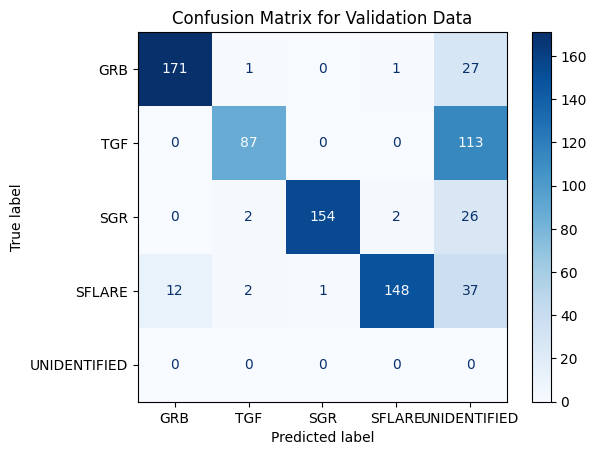

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

threshold = 0.7

def predict_with_unidentified(model, data, threshold=0.7):
    predictions = model.predict(data)
    max_prob = np.max(predictions, axis=1)
    labels = np.argmax(predictions, axis=1)
    labels[max_prob < threshold] = 4
    
    unidentified_count = np.sum(max_prob < threshold)
    return labels, unidentified_count

# Evaluate on training data
train_predictions, train_unidentified_count = predict_with_unidentified(model, X_train, threshold)
train_accuracy = np.mean(train_predictions == np.argmax(Y_train, axis=1))
print(f'\nAccuracy on training data with unidentified class: {train_accuracy}\n\n')

# Evaluate on validation data
test_predictions, test_unidentified_count = predict_with_unidentified(model, X_test, threshold)

# Check if Y_test is one-hot encoded or not
if Y_test.ndim > 1:
    print("Yes")
    test_true_labels = np.argmax(Y_test, axis=1)
else:
    test_true_labels = Y_test

test_accuracy = np.mean(test_predictions == test_true_labels)
print(f'Accuracy on test data with unidentified class: {test_accuracy}')

print(f'Number of unidentified instances in training data: {train_unidentified_count}')
print(f'Number of unidentified instances in test data: {test_unidentified_count}')

print("confusion matrix")
conf_matrix = confusion_matrix(test_true_labels, test_predictions, labels=[0, 1, 2, 3, 4])

plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=['GRB', 'TGF', 'SGR', 'SFLARE', 'UNIDENTIFIED'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Validation Data')
plt.show()



In [17]:
def calculate_avg_confidence_for_correct_predictions(model, X, Y):
    predictions = model.predict(X)
    max_probs = np.max(predictions, axis=1)  # Max probability from softmax
    predicted_labels = np.argmax(predictions, axis=1)
    
    # Check if Y is one-hot encoded
    if Y.ndim == 2:  # One-hot encoded case
        true_labels = np.argmax(Y, axis=1)
    else:  # Already class labels
        true_labels = Y
        
    # Filter only correct predictions
    correct_predictions_mask = (predicted_labels == true_labels)
    #print(max_probs[correct_predictions_mask])
    # Calculate the average probability for correct predictions
    avg_confidence_correct = np.mean(max_probs[correct_predictions_mask])
    
    return avg_confidence_correct

# Calculate the threshold based on correct predictions
optimal_threshold = calculate_avg_confidence_for_correct_predictions(model, X_test, Y_test)
print(f'Optimal confidence threshold based on correct predictions: {optimal_threshold}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Optimal confidence threshold based on correct predictions: 0.9002116322517395


In [18]:
def calculate_classwise_confidence_thresholds(model, X, Y, num_classes):
    predictions = model.predict(X)
    max_probs = np.max(predictions, axis=1)
    predicted_labels = np.argmax(predictions, axis=1)
    # Check if Y is one-hot encoded
    if Y.ndim == 2:  # One-hot encoded case
        true_labels = np.argmax(Y, axis=1)
    else:  # Already class labels
        true_labels = Y
    
    classwise_thresholds = {}

    for class_idx in range(num_classes):
        # Filter predictions for the current class
        correct_class_mask = (true_labels == class_idx) & (predicted_labels == class_idx)
        if np.sum(correct_class_mask) > 0:  # Ensure we have correct predictions for this class
            avg_confidence = np.mean(max_probs[correct_class_mask])
            classwise_thresholds[class_idx] = avg_confidence
        else:
            classwise_thresholds[class_idx] = None  # If no correct predictions exist for this class

    return classwise_thresholds

# Assuming you have 4 classes (GRB, TGF, SGR, SFLARE)
classwise_thresholds = calculate_classwise_confidence_thresholds(model, X_test, Y_test, num_classes=4)
print(f'Class-specific confidence thresholds: {classwise_thresholds}')


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Class-specific confidence thresholds: {0: 0.9253015, 1: 0.750883, 2: 0.99503535, 3: 0.9680821}
